# Kalman Filter 

In [1]:
def Kalman_Filter(Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = param0[0]
    T = param0[1]
    H = param0[2]
    Q = param0[3]
    # "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    KF_Dens = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
            Likelihood = np.sum(KF_Dens[1:-1])  
            return Likelihood

In [2]:
def Kalman_Smoother(params, Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            # "Please fill this part."
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    
            u_smooth = np.zeros(S)
            P_smooth = np.zeros(S)
            u_smooth[S-1] = u_update[S-1]
            P_smooth[S-1] = P_update[S-1]    
    for  t in range(S-1,0,-1):
     
        u_smooth[t-1] = u_update[t] +P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]- T*u_update[t])
        P_smooth[t-1] = P_update[t] + (P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_update[t])/P_update[t]*T*P_update[t])
    
    u_smooth = u_smooth[0:-1]
    return u_smooth

# Implementing the Kalman Model

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import pandas_datareader as web

In [4]:
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2022, 1, 1)

df_visa = web.DataReader('V', 'yahoo', start, end) 

visa= df_visa
visa=visa.reset_index()
visa['Date'] = pd.to_datetime(visa['Date'])
visa['Typical_Price'] = visa[['High','Low','Close']].mean(axis=1)
visa['lrets'] = (np.log(visa.Close) - np.log(visa.Close.shift(1))) * 100.
visa.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Typical_Price,lrets
0,2018-01-02,115.080002,113.949997,114.570000,114.510002,6080900.0,111.468170,114.513334,NaN
1,2018-01-03,115.790001,114.660004,114.949997,115.650002,6946100.0,112.577881,115.366669,0.990623
2,2018-01-04,117.360001,116.029999,116.250000,116.080002,7805300.0,112.996475,116.490000,0.371122
3,2018-01-05,119.000000,116.419998,116.989998,118.860001,8590500.0,115.702614,118.093333,2.366671
4,2018-01-08,120.480003,118.070000,118.610001,119.339996,6660700.0,116.169846,119.296666,0.403020


In [5]:
visa.shape

(1008, 9)

C:\Users\Srushti\AppData\Local\Temp/ipykernel_22064/2582600238.py:7: OptimizeWarning: Unknown solver options: xtol
  param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1


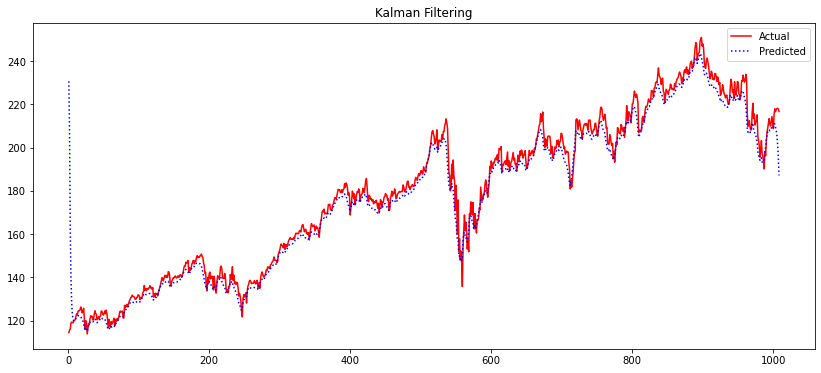

In [6]:
Y = visa['Close']
T = Y.shape[0]
mu = 1196;


param0 = np.array([0.3, 0.9, 0.8, 1.1])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
y_pred = Kalman_Smoother(param_star.x, Y)

timevec = np.linspace(1,T,T)


fig= plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, y_pred,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("Kalman Filtering")
plt.show()

In [7]:
results = pd.DataFrame({'Actual': list(Y),
                  'Predicted' : list(y_pred),
                  'Date':visa['Date'],
                  'Open':visa['Open'],
                  'Close':visa['Close']
                       })


In [8]:
results.set_index('Date',inplace = True)
results.head(10)

,Actual,Predicted,Open,Close
Date,,,,
2018-01-02,114.510002,230.650057,114.570000,114.510002
2018-01-03,115.650002,207.866957,114.949997,115.650002
2018-01-04,116.080002,162.968945,116.250000,116.080002
2018-01-05,118.860001,140.102862,116.989998,118.860001
2018-01-08,119.339996,128.433784,118.610001,119.339996
2018-01-09,119.110001,122.881522,119.970001,119.110001
2018-01-10,118.980003,120.558627,118.690002,118.980003
2018-01-11,119.839996,119.920073,118.800003,119.839996
2018-01-12,120.089996,119.861987,120.120003,120.089996


# Long Short Day trading:
* if predicted > yesterdays close, buy and sell at end of day

* if predicted < yesterdays close, sell and buy at end of day

In [9]:
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results)-1):
    if results['Predicted'][i] > results['Actual'][i-1]:
        action.append('Buy at Open & Sell at Close')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Buy at Open',round(portfolio,2),stocks,round(balance,2))
        
        
        # action.append('Sell at End')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Sell at Close',round(amount,2),balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio,5))
        
    else:
        action.append('Sell at Open & Buy at Close')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Sell at Open',round(portfolio,2),'-',stocks,round(balance,2))
        
        
        # action.append('Buy at Close')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Buy Back at Close',round(amount,2),balance)
        Amount.append(amount)
        # add by Hongbo
        Portfolio.append(round(portfolio,5))
    print('\n')
        

0 Buy at Open 9967.59 87 37
0 Sell at Close 9999.37 0


1 Buy at Open 9885.7 86 53
1 Sell at Close 9998.9 0


2 Buy at Open 9997.5 86 16
2 Sell at Close 9998.88 0


3 Buy at Open 9944.15 85 14
3 Sell at Close 10117.1 0


4 Buy at Open 10081.85 85 92
4 Sell at Close 10235.9 0


5 Buy at Open 10197.45 85 111
5 Sell at Close 10235.35 0


6 Buy at Open 10207.34 86 3
6 Sell at Close 10235.28 0


7 Buy at Open 10216.8 86 48
7 Sell at Close 10354.24 0


8 Buy at Open 10330.32 86 26
8 Sell at Close 10353.74 0


9 Buy at Open 10300.3 85 0
9 Sell at Close 10233.15 0


10 Buy at Open 10180.8 84 108
10 Sell at Close 10354.32 0


11 Sell at Open 10291.68 - 84 13
11 Buy Back at Close 10354.24 0


12 Sell at Open 10336.2 - 84 47
12 Buy Back at Close 10353.8 0


13 Sell at Open 10321.08 - 84 34
13 Buy Back at Close 10477.72 0


14 Sell at Open 10466.4 - 84 7
14 Buy Back at Close 10477.6 0


15 Sell at Open 10379.15 - 83 15
15 Buy Back at Close 10352.65 0


16 Sell at Open 10250.0 - 82 84
16 Buy Back a

167 Sell at Open 10571.04 - 72 28
167 Buy Back at Close 10593.28 0


168 Sell at Open 10565.28 - 72 17
168 Buy Back at Close 10593.08 0


169 Sell at Open 10578.96 - 72 99
169 Buy Back at Close 10740.6 0


170 Sell at Open 10731.0 - 73 40
170 Buy Back at Close 10454.91 0


171 Sell at Open 10316.88 - 72 50
171 Buy Back at Close 10454.0 0


172 Sell at Open 10367.28 - 72 0
172 Buy Back at Close 10310.4 0


173 Buy at Open 10233.23 71 80
173 Sell at Close 10309.68 0


174 Sell at Open 10185.66 - 71 125
174 Buy Back at Close 10454.79 0


175 Sell at Open 10355.35 - 71 48
175 Buy Back at Close 10454.47 0


176 Sell at Open 10447.65 - 71 120
176 Buy Back at Close 10601.73 0


177 Sell at Open 10501.61 - 71 105
177 Buy Back at Close 10601.64 0


178 Sell at Open 10495.93 - 71 76
178 Buy Back at Close 10454.78 0


179 Sell at Open 10380.2 - 71 120
179 Buy Back at Close 10601.73 0


180 Sell at Open 10527.88 - 71 134
180 Buy Back at Close 10600.82 0


181 Sell at Open 10507.29 - 71 4
181 Buy B

314 Sell at Open 10305.75 - 65 2
314 Buy Back at Close 10301.9 0


315 Sell at Open 10145.92 - 64 55
315 Buy Back at Close 10143.96 0


316 Sell at Open 10112.0 - 64 54
316 Buy Back at Close 10143.6 0


317 Sell at Open 10083.2 - 64 47
317 Buy Back at Close 10143.0 0


318 Sell at Open 10019.84 - 64 63
318 Buy Back at Close 10142.36 0


319 Sell at Open 10111.36 - 64 153
319 Buy Back at Close 10300.84 0


320 Sell at Open 10183.04 - 64 39
320 Buy Back at Close 10142.04 0


321 Sell at Open 9998.73 - 63 84
321 Buy Back at Close 10141.32 0


322 Sell at Open 10069.29 - 63 33
322 Buy Back at Close 10140.72 0


323 Sell at Open 9984.48 - 62 46
323 Buy Back at Close 9980.26 0


324 Sell at Open 9973.94 - 62 32
324 Buy Back at Close 9979.28 0


325 Sell at Open 9977.66 - 62 49
325 Buy Back at Close 9978.92 0


326 Sell at Open 9870.4 - 62 34
326 Buy Back at Close 9978.8 0


327 Sell at Open 9821.0 - 61 117
327 Buy Back at Close 9978.26 0


328 Sell at Open 9866.75 - 61 127
328 Buy Back at Cl

452 Buy Back at Close 8814.5 0


453 Sell at Open 8800.0 - 50 169
453 Buy Back at Close 8990.5 0


454 Sell at Open 8850.0 - 50 105
454 Buy Back at Close 8648.0 0


455 Buy at Open 8549.5 50 81
455 Sell at Close 8647.0 0


456 Buy at Open 8497.58 49 15
456 Sell at Close 8646.84 0


457 Sell at Open 8571.57 - 49 110
457 Buy Back at Close 8824.65 0


458 Sell at Open 8767.57 - 49 12
458 Buy Back at Close 8824.16 0


459 Sell at Open 8810.2 - 49 120
459 Buy Back at Close 8823.87 0


460 Sell at Open 8711.71 - 49 40
460 Buy Back at Close 8823.25 0


461 Sell at Open 8783.25 - 49 59
461 Buy Back at Close 8823.14 0


462 Sell at Open 8646.24 - 48 138
462 Buy Back at Close 8822.64 0


463 Sell at Open 8739.84 - 48 54
463 Buy Back at Close 8643.6 0


464 Sell at Open 8595.36 - 48 1
464 Buy Back at Close 8466.76 0


465 Sell at Open 8465.76 - 48 158
465 Buy Back at Close 8642.96 0


466 Sell at Open 8512.8 - 48 78
466 Buy Back at Close 8642.64 0


467 Sell at Open 8562.24 - 48 52
467 Buy Back a

591 Sell at Open 8881.44 - 48 64
591 Buy Back at Close 8948.32 0


592 Sell at Open 8825.76 - 48 137
592 Buy Back at Close 8947.88 0


593 Sell at Open 8810.88 - 48 153
593 Buy Back at Close 8767.56 0


594 Buy at Open 8746.5 49 90
594 Sell at Close 8767.41 0


595 Buy at Open 8621.06 49 84
595 Sell at Close 8948.1 0


596 Buy at Open 8819.02 49 140
596 Sell at Close 9131.01 0


597 Buy at Open 9024.0 48 136
597 Sell at Close 9322.24 0


598 Sell at Open 9174.72 - 48 43
598 Buy Back at Close 9132.28 0


599 Sell at Open 9071.0 - 47 20
599 Buy Back at Close 9131.42 0


600 Sell at Open 9094.5 - 47 172
600 Buy Back at Close 9131.14 0


601 Sell at Open 8977.0 - 47 160
601 Buy Back at Close 9130.42 0


602 Sell at Open 9006.8 - 46 49
602 Buy Back at Close 8937.12 0


603 Sell at Open 8743.95 - 45 67
603 Buy Back at Close 8743.9 0


604 Sell at Open 8709.3 - 45 2
604 Buy Back at Close 8743.7 0


605 Sell at Open 8558.0 - 44 153
605 Buy Back at Close 8743.56 0


606 Sell at Open 8567.24 - 4

789 Buy at Open 7327.8 36 161
789 Sell at Close 7660.52 0


790 Buy at Open 7466.4 36 24
790 Sell at Close 7659.96 0


791 Buy at Open 7644.96 36 199
791 Sell at Close 8098.48 0


792 Sell at Open 7894.44 - 36 189
792 Buy Back at Close 7884.0 0


793 Sell at Open 7705.8 - 36 25
793 Buy Back at Close 7671.04 0


794 Sell at Open 7523.95 - 35 88
794 Buy Back at Close 7670.05 0


795 Sell at Open 7593.6 - 35 118
795 Buy Back at Close 7669.95 0


796 Sell at Open 7530.25 - 35 150
796 Buy Back at Close 7669.75 0


797 Sell at Open 7558.95 - 35 55
797 Buy Back at Close 7457.5 0


798 Buy at Open 7266.82 34 133
798 Sell at Close 7456.94 0


799 Buy at Open 7377.32 34 188
799 Sell at Close 7677.18 0


800 Sell at Open 7550.04 - 34 184
800 Buy Back at Close 7676.24 0


801 Sell at Open 7504.48 - 34 88
801 Buy Back at Close 7675.78 0


802 Sell at Open 7634.02 - 34 212
802 Buy Back at Close 7901.1 0


803 Sell at Open 7884.8 - 35 48
803 Buy Back at Close 7900.6 0


804 Sell at Open 7848.05 - 35 

913 Sell at Open 7953.28 - 34 158
913 Buy Back at Close 8033.42 0


914 Sell at Open 8016.4 - 35 160
914 Buy Back at Close 8264.95 0


915 Sell at Open 8115.45 - 35 167
915 Buy Back at Close 8264.6 0


916 Sell at Open 8144.5 - 35 69
916 Buy Back at Close 8263.9 0


917 Sell at Open 8226.4 - 35 65
917 Buy Back at Close 8263.4 0


918 Sell at Open 8225.0 - 35 122
918 Buy Back at Close 8262.65 0


919 Sell at Open 8124.55 - 35 194
919 Buy Back at Close 8262.2 0


920 Sell at Open 8085.7 - 35 118
920 Buy Back at Close 8262.15 0


921 Sell at Open 8144.15 - 35 169
921 Buy Back at Close 8262.05 0


922 Sell at Open 8081.85 - 35 14
922 Buy Back at Close 8032.5 0


923 Sell at Open 8018.5 - 35 208
923 Buy Back at Close 8262.2 0


924 Sell at Open 8065.05 - 35 191
924 Buy Back at Close 8037.3 0


925 Sell at Open 7840.0 - 35 158
925 Buy Back at Close 8036.85 0


926 Sell at Open 7935.9 - 35 117
926 Buy Back at Close 8036.45 0


927 Sell at Open 7958.3 - 35 18
927 Buy Back at Close 8036.15 0




In [10]:
len(Amount)

1007

In [11]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':visa.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': visa.Date[1:],
                                 'Action':  action,
                                 # 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Portfolio($),Amount($)
1,115.650002,207.866957,2018-01-03,Buy at Open & Sell at Close,0,9999.370186
2,116.080002,162.968945,2018-01-04,Buy at Open & Sell at Close,0,9998.900131
3,118.860001,140.102862,2018-01-05,Buy at Open & Sell at Close,0,9998.880157
4,119.339996,128.433784,2018-01-08,Buy at Open & Sell at Close,0,10117.100052
5,119.110001,122.881522,2018-01-09,Buy at Open & Sell at Close,0,10235.899689


<AxesSubplot:title={'center':'Total Amount'}>

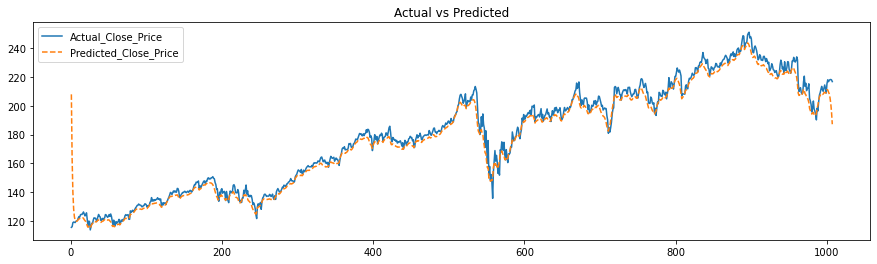

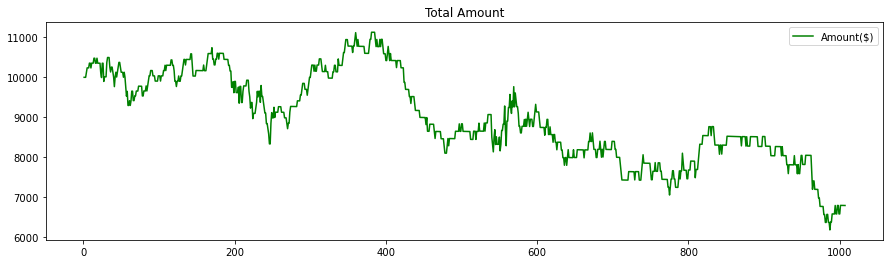

In [12]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [13]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 6787.9698486328125 $
Profit_Percent: 67.87969848632812 %


* Sharpe Ratio

In [14]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [15]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

-0.0002564031384492843 0.016037141174912645


-0.4734740497910146

# Buy & Hold Trading Strategy
 
* Position trading 
* Buy if we have next days predicted_value greater than todays close value and hold if already bought 
* Sell if we have next days predicted_value lesser than todays close value and dont buy until rule 1

In [16]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i+1] > results['Actual'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i+1] < results['Actual'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    print('\n')
    

Stock: 114.51000213623047 Action: Buy Portfolio: 9962.37 Stocks: 87 Balance_init: 37 total($) 9999.37


Stock: 115.6500015258789 Action: Bought--Holding Portfolio: 10061.55 Stocks: 87 Balance_init: 37 total($) 10098.55


Stock: 116.08000183105469 Action: Bought--Holding Portfolio: 10098.96 Stocks: 87 Balance_init: 37 total($) 10135.96


Stock: 118.86000061035156 Action: Bought--Holding Portfolio: 10340.82 Stocks: 87 Balance_init: 37 total($) 10377.82


Stock: 119.33999633789062 Action: Bought--Holding Portfolio: 10382.58 Stocks: 87 Balance_init: 37 total($) 10419.58


Stock: 119.11000061035156 Action: Bought--Holding Portfolio: 10362.57 Stocks: 87 Balance_init: 37 total($) 10399.57


Stock: 118.9800033569336 Action: Bought--Holding Portfolio: 10351.26 Stocks: 87 Balance_init: 37 total($) 10388.26


Stock: 119.83999633789062 Action: Bought--Holding Portfolio: 10426.08 Stocks: 87 Balance_init: 37 total($) 10463.08


Stock: 120.08999633789062 Action: Bought--Holding Portfolio: 10447.83 St

Stock: 120.75 Action: Buy Portfolio: 12558.0 Stocks: 104 Balance_init: 61 total($) 12619.0


Stock: 121.87999725341797 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12736.52


Stock: 123.80000305175781 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12736.52


Stock: 124.4800033569336 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12736.52


Stock: 123.95999908447266 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12736.52


Stock: 124.19999694824219 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12736.52


Stock: 124.45999908447266 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 12736.52


Stock: 121.2699966430664 Action: Buy Portfolio: 12733.35 Stocks: 105 Balance_init: 3 total($) 12736.35


Stock: 121.20999908447266 Action: Bought--Holding Portfolio: 12727.05 Stocks: 105 Bal

Stock: 145.49000549316406 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14819.16


Stock: 146.57000732421875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14819.16


Stock: 147.6300048828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14819.16


Stock: 147.83999633789062 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14819.16


Stock: 146.17999267578125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14819.16


Stock: 147.6300048828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14819.16


Stock: 147.4199981689453 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14819.16


Stock: 149.24000549316406 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 14819.16


Stock: 150.

Stock: 137.27999877929688 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 20796.12


Stock: 138.5 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 20796.12


Stock: 138.0500030517578 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 20796.12


Stock: 137.00999450683594 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 20796.12


Stock: 137.6999969482422 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 20796.12


Stock: 138.6699981689453 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 20796.12


Stock: 135.99000549316406 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 20796.12


Stock: 135.0 Action: Buy Portfolio: 20790.0 Stocks: 154 Balance_init: 6 total($) 20796.0


Stock: 137.60000610351562 Action: Sell Portfolio: 0 Stock

Stock: 157.3300018310547 Action: Buy Portfolio: 22970.18 Stocks: 146 Balance_init: 86 total($) 23056.18


Stock: 160.2100067138672 Action: Bought--Holding Portfolio: 23390.66 Stocks: 146 Balance_init: 86 total($) 23476.66


Stock: 162.7899932861328 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 23853.34


Stock: 164.8699951171875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 23853.34


Stock: 164.08999633789062 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 23853.34


Stock: 163.47000122070312 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 23853.34


Stock: 163.86000061035156 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 23853.34


Stock: 164.24000549316406 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 23853.34


Stock: 161.50999450683594 Action: Price-Prediction-Already-L

Stock: 174.05999755859375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 27925.63


Stock: 174.91000366210938 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 27925.63


Stock: 174.47999572753906 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 27925.63


Stock: 175.27999877929688 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 27925.63


Stock: 175.64999389648438 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 27925.63


Stock: 174.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 27925.63


Stock: 172.00999450683594 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 27925.63


Stock: 174.2899932861328 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 27925.63


Stock: 169.83000183105

Stock: 207.44000244140625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32446.41


Stock: 207.39999389648438 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32446.41


Stock: 210.2899932861328 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32446.41


Stock: 211.1999969482422 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32446.41


Stock: 213.30999755859375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32446.41


Stock: 211.4499969482422 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32446.41


Stock: 208.80999755859375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32446.41


Stock: 198.7899932861328 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 32446.41


Stock: 188.3

Stock: 196.8699951171875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 57499.0


Stock: 193.63999938964844 Action: Buy Portfolio: 57317.44 Stocks: 296 Balance_init: 181 total($) 57498.44


Stock: 199.61000061035156 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 59265.56


Stock: 199.60000610351562 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 59265.56


Stock: 199.0800018310547 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 59265.56


Stock: 200.47999572753906 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 59265.56


Stock: 188.8800048828125 Action: Buy Portfolio: 59119.44 Stocks: 313 Balance_init: 146 total($) 59265.44


Stock: 192.25999450683594 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 60323.38


Stock: 191.75999450683594 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_

Stock: 202.47000122070312 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 68733.0


Stock: 202.97999572753906 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 68733.0


Stock: 206.63999938964844 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 68733.0


Stock: 206.39999389648438 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 68733.0


Stock: 204.32000732421875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 68733.0


Stock: 202.1999969482422 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 68733.0


Stock: 199.5500030517578 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 68733.0


Stock: 200.25999450683594 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 68733.0


Stock: 196.9700012

Stock: 198.36000061035156 Action: Bought--Holding Portfolio: 88865.28 Stocks: 448 Balance_init: 74 total($) 88939.28


Stock: 202.61000061035156 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 90843.28


Stock: 201.36000061035156 Action: Buy Portfolio: 90813.36 Stocks: 451 Balance_init: 29 total($) 90842.36


Stock: 209.25 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 94400.75


Stock: 208.77000427246094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 94400.75


Stock: 206.88999938964844 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 94400.75


Stock: 206.52000427246094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 94400.75


Stock: 206.44000244140625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 94400.75


Stock: 210.66000366210938 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balanc

Stock: 234.08999633789062 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 118497.6


Stock: 235.9499969482422 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 118497.6


Stock: 233.82000732421875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 118497.6


Stock: 235.14999389648438 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 118497.6


Stock: 238.6300048828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 118497.6


Stock: 239.60000610351562 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 118497.6


Stock: 240.0 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 118497.6


Stock: 236.61000061035156 Action: Buy Portfolio: 118305.0 Stocks: 500 Balance_init: 192 total($) 118497.0


Stock: 238.47000122070312 Action: Sell 

Stock: 230.99000549316406 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 135605.13


Stock: 230.64999389648438 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 135605.13


Stock: 233.52000427246094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 135605.13


Stock: 231.4199981689453 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 135605.13


Stock: 230.24000549316406 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 135605.13


Stock: 231.22999572753906 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 135605.13


Stock: 233.8800048828125 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 135605.13


Stock: 231.82000732421875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 135605.13


Stock: 215.77999877929688 Ac

In [17]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':visa.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': visa.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,115.650002,207.866957,2018-01-03,Buy,87,9962.37019,9999.0
2,116.080002,162.968945,2018-01-04,Bought--Holding,87,10061.55013,10099.0
3,118.860001,140.102862,2018-01-05,Bought--Holding,87,10098.96016,10136.0
4,119.339996,128.433784,2018-01-08,Bought--Holding,87,10340.82005,10378.0
5,119.110001,122.881522,2018-01-09,Bought--Holding,87,10382.57968,10420.0


<AxesSubplot:title={'center':'Total Amount'}>

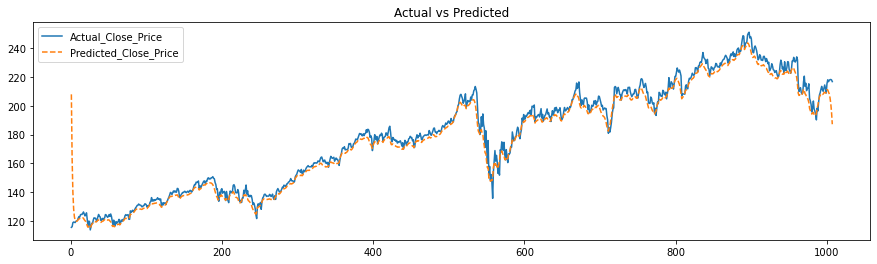

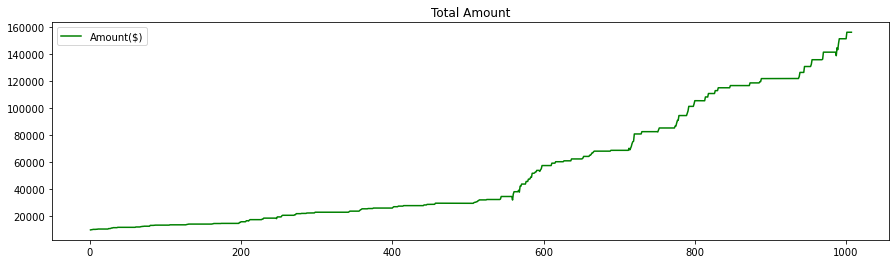

In [18]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [19]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 155885.0 $
Profit_Percent: 1558.85 %


* Sharpe Ratio

In [20]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [21]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.0027887706586629236 0.010656058340689391


7.7502552792689725

# Buy & Hold Trading Strategy with bollinger bands

In [22]:
long_MA = results['Actual'].rolling(window=20).mean()
results['Long_Moving_Avg'] = long_MA

In [23]:
short_MA  = results['Actual'].rolling(window=5).mean()
results['Short_Moving_Avg'] = short_MA 

In [24]:
long_std= results['Actual'].rolling(window=20).std()
results['Long_std'] = long_std

In [25]:
long_upper_band = ((long_MA) + (long_std)*0.75)
results['Long_Upper_Band'] = long_upper_band

In [26]:
long_lower_band = ((long_MA) - (long_std)*0.75)
results['Long_Lower_Band'] = long_lower_band

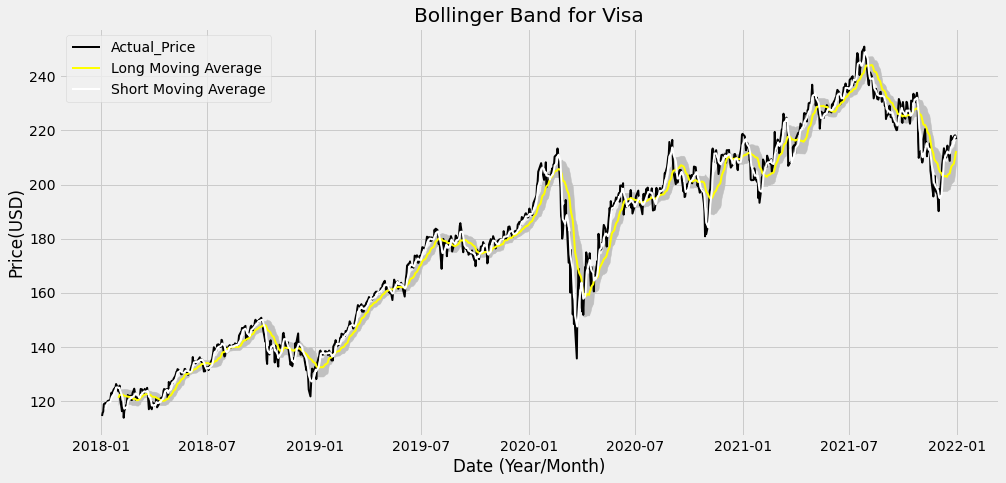

In [27]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
x_axis = results.index
ax.fill_between(x_axis, results['Long_Upper_Band'], results['Long_Lower_Band'], color='silver')
ax.plot(x_axis, results['Actual'], color='black', lw=2, label = 'Actual_Price')
ax.plot(x_axis, results['Long_Moving_Avg'], color='yellow', lw=2, label = 'Long Moving Average')
ax.plot(x_axis, results['Short_Moving_Avg'], color='white', lw=2, label = 'Short Moving Average')

ax.set_title('Bollinger Band for Visa')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price(USD)')
ax.legend()
plt.show()

In [28]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Predicted'][i] > results['Long_Lower_Band'][i]:
        if signal == 0:
            
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Predicted'][i] < results['Long_Moving_Avg'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
    else:
        action.append('Do nothing')
        print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
        Portfolio.append(round(portfolio,5))
        Amount.append(round(amount,0))
        Stocks.append(stocks)

            
    print('\n')
    

Stock: 114.51000213623047 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 115.6500015258789 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 116.08000183105469 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 118.86000061035156 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 119.33999633789062 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 119.11000061035156 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 118.9800033569336 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 119.83999633789062 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 120.08999633789062 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 120.38999938964844 Action: Do nothing Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 

Stock: 139.89999389648438 Action: Bought--Holding Portfolio: 12031.4 Stocks: 86 Balance_init: 82 total($) 12113.4


Stock: 139.4199981689453 Action: Bought--Holding Portfolio: 11990.12 Stocks: 86 Balance_init: 82 total($) 12072.12


Stock: 138.4600067138672 Action: Bought--Holding Portfolio: 11907.56 Stocks: 86 Balance_init: 82 total($) 11989.56


Stock: 139.63999938964844 Action: Bought--Holding Portfolio: 12009.04 Stocks: 86 Balance_init: 82 total($) 12091.04


Stock: 140.89999389648438 Action: Bought--Holding Portfolio: 12117.4 Stocks: 86 Balance_init: 82 total($) 12199.4


Stock: 140.1300048828125 Action: Bought--Holding Portfolio: 12051.18 Stocks: 86 Balance_init: 82 total($) 12133.18


Stock: 140.99000549316406 Action: Bought--Holding Portfolio: 12125.14 Stocks: 86 Balance_init: 82 total($) 12207.14


Stock: 140.02999877929688 Action: Bought--Holding Portfolio: 12042.58 Stocks: 86 Balance_init: 82 total($) 12124.58


Stock: 140.02999877929688 Action: Bought--Holding Portfolio: 12

Stock: 130.22999572753906 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 13026.52


Stock: 132.00999450683594 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 13026.52


Stock: 130.94000244140625 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 13026.52


Stock: 131.94000244140625 Action: Buy Portfolio: 12930.12 Stocks: 98 Balance_init: 96 total($) 13026.12


Stock: 132.9199981689453 Action: Bought--Holding Portfolio: 13026.16 Stocks: 98 Balance_init: 96 total($) 13122.16


Stock: 128.1300048828125 Action: Bought--Holding Portfolio: 12556.74 Stocks: 98 Balance_init: 96 total($) 12652.74


Stock: 133.64999389648438 Action: Bought--Holding Portfolio: 13097.7 Stocks: 98 Balance_init: 96 total($) 13193.7


Stock: 136.05999755859375 Action: Bought--Holding Portfolio: 13333.88 Stocks: 98 Balance_init: 96 total($) 13429.88


Stock: 136.8000030517578 Action: Bought--Holding Portf



Stock: 169.35000610351562 Action: Bought--Holding Portfolio: 16935.0 Stocks: 100 Balance_init: 91 total($) 17026.0


Stock: 169.66000366210938 Action: Bought--Holding Portfolio: 16966.0 Stocks: 100 Balance_init: 91 total($) 17057.0


Stock: 169.55999755859375 Action: Bought--Holding Portfolio: 16956.0 Stocks: 100 Balance_init: 91 total($) 17047.0


Stock: 169.27999877929688 Action: Bought--Holding Portfolio: 16928.0 Stocks: 100 Balance_init: 91 total($) 17019.0


Stock: 170.69000244140625 Action: Bought--Holding Portfolio: 17069.0 Stocks: 100 Balance_init: 91 total($) 17160.0


Stock: 173.74000549316406 Action: Bought--Holding Portfolio: 17374.0 Stocks: 100 Balance_init: 91 total($) 17465.0


Stock: 173.44000244140625 Action: Bought--Holding Portfolio: 17344.0 Stocks: 100 Balance_init: 91 total($) 17435.0


Stock: 173.85000610351562 Action: Bought--Holding Portfolio: 17385.0 Stocks: 100 Balance_init: 91 total($) 17476.0


Stock: 171.27999877929688 Action: Bought--Holding Portfolio: 1

Stock: 207.89999389648438 Action: Bought--Holding Portfolio: 22245.3 Stocks: 107 Balance_init: 86 total($) 22331.3


Stock: 206.52000427246094 Action: Bought--Holding Portfolio: 22097.64 Stocks: 107 Balance_init: 86 total($) 22183.64


Stock: 205.0 Action: Bought--Holding Portfolio: 21935.0 Stocks: 107 Balance_init: 86 total($) 22021.0


Stock: 201.69000244140625 Action: Bought--Holding Portfolio: 21580.83 Stocks: 107 Balance_init: 86 total($) 21666.83


Stock: 202.85000610351562 Action: Bought--Holding Portfolio: 21704.95 Stocks: 107 Balance_init: 86 total($) 21790.95


Stock: 204.86000061035156 Action: Bought--Holding Portfolio: 21920.02 Stocks: 107 Balance_init: 86 total($) 22006.02


Stock: 208.2100067138672 Action: Bought--Holding Portfolio: 22278.47 Stocks: 107 Balance_init: 86 total($) 22364.47


Stock: 198.97000122070312 Action: Bought--Holding Portfolio: 21289.79 Stocks: 107 Balance_init: 86 total($) 21375.79


Stock: 200.80999755859375 Action: Bought--Holding Portfolio: 21486

Stock: 211.99000549316406 Action: Bought--Holding Portfolio: 29890.59 Stocks: 141 Balance_init: 144 total($) 30034.59


Stock: 213.35000610351562 Action: Bought--Holding Portfolio: 30082.35 Stocks: 141 Balance_init: 144 total($) 30226.35


Stock: 216.47999572753906 Action: Bought--Holding Portfolio: 30523.68 Stocks: 141 Balance_init: 144 total($) 30667.68


Stock: 208.9600067138672 Action: Bought--Holding Portfolio: 29463.36 Stocks: 141 Balance_init: 144 total($) 29607.36


Stock: 204.66000366210938 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29001.06


Stock: 200.1199951171875 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29001.06


Stock: 204.05999755859375 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29001.06


Stock: 201.5399932861328 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29001.06


Stock: 200.67999267578125 Action: Price-Prediction-Al

Stock: 225.7899932861328 Action: Bought--Holding Portfolio: 38610.09 Stocks: 171 Balance_init: 110 total($) 38720.09


Stock: 223.27999877929688 Action: Bought--Holding Portfolio: 38180.88 Stocks: 171 Balance_init: 110 total($) 38290.88


Stock: 227.4499969482422 Action: Bought--Holding Portfolio: 38893.95 Stocks: 171 Balance_init: 110 total($) 39003.95


Stock: 227.57000732421875 Action: Bought--Holding Portfolio: 38914.47 Stocks: 171 Balance_init: 110 total($) 39024.47


Stock: 230.0 Action: Bought--Holding Portfolio: 39330.0 Stocks: 171 Balance_init: 110 total($) 39440.0


Stock: 230.33999633789062 Action: Bought--Holding Portfolio: 39388.14 Stocks: 171 Balance_init: 110 total($) 39498.14


Stock: 229.91000366210938 Action: Bought--Holding Portfolio: 39314.61 Stocks: 171 Balance_init: 110 total($) 39424.61


Stock: 233.4499969482422 Action: Bought--Holding Portfolio: 39919.95 Stocks: 171 Balance_init: 110 total($) 40029.95


Stock: 236.86000061035156 Action: Bought--Holding Portfoli

Stock: 203.3300018310547 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 42875.7


Stock: 200.86000061035156 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 42875.7


Stock: 195.5800018310547 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 42875.7


Stock: 198.49000549316406 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 42875.7


Stock: 203.25 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 42875.7


Stock: 197.64999389648438 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 42875.7


Stock: 196.2899932861328 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 42875.7


Stock: 193.77000427246094 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 42875.7


Stock: 190.16000366210938 Actio

In [29]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':visa.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': visa.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,115.650002,207.866957,2018-01-03,Do nothing,0,0.0,10000.0
2,116.080002,162.968945,2018-01-04,Do nothing,0,0.0,10000.0
3,118.860001,140.102862,2018-01-05,Do nothing,0,0.0,10000.0
4,119.339996,128.433784,2018-01-08,Do nothing,0,0.0,10000.0
5,119.110001,122.881522,2018-01-09,Do nothing,0,0.0,10000.0


<AxesSubplot:title={'center':'Total Amount'}>

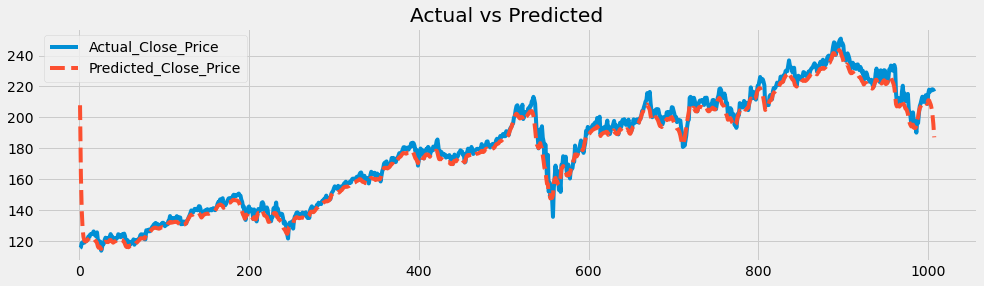

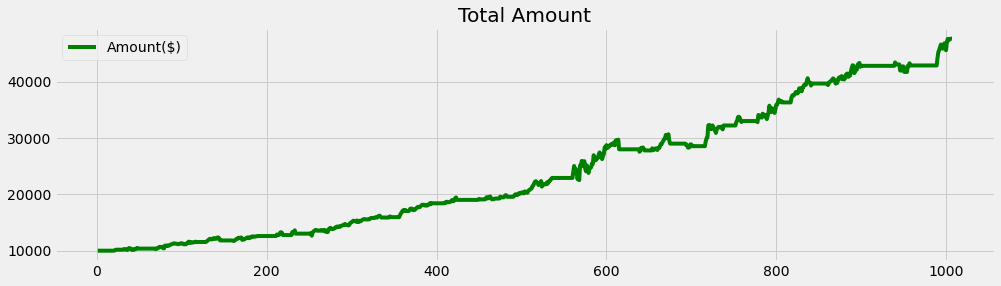

In [30]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [31]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 47638.0 $
Profit_Percent: 476.38 %


* Sharpe Ratio

In [32]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [33]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.0016159802249523694 0.011291880785058168


4.23808394062251

# Buy & Hold Trading Strategy with MACD

In [34]:
import numpy as np
import pandas as pd
def calculateEMA(period, closeArray, emaArray=[]):
    length = len(closeArray)
    nanCounter = np.count_nonzero(np.isnan(closeArray))
    if not emaArray:
        emaArray.extend(np.tile([np.nan],(nanCounter + period - 1)))
        firstema = np.mean(closeArray[nanCounter:nanCounter + period - 1])    
        emaArray.append(firstema)    
        for i in range(nanCounter+period,length):
            ema=(2*closeArray[i]+(period-1)*emaArray[-1])/(period+1)
            emaArray.append(ema)        
    return np.array(emaArray)
    
def calculateMACD(closeArray,shortPeriod = 12 ,longPeriod = 26 ,signalPeriod =9):
    ema12 = calculateEMA(shortPeriod ,closeArray,[])
    print(ema12)
    ema26 = calculateEMA(longPeriod ,closeArray,[])
    print(ema26)
    diff = ema12-ema26
    
    dea= calculateEMA(signalPeriod ,diff,[])
    macd = 2*(diff-dea)
    return macd,diff,dea

In [35]:
macd, diff, dea=calculateMACD(results['Actual'])

[         nan          nan          nan ... 214.38887003 214.92442774
 215.19913219]
[         nan          nan          nan ... 211.77763298 212.22891907
 212.56085149]


In [36]:
results['Macd'] = macd

In [37]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(results)-1):
    if results['Macd'][i] > 0:
        if signal == 0:
            
            action.append('Buy')
            stocks = int(amount / results['Actual'][i])
            balance = int(amount % results['Actual'][i])
            portfolio = stocks * results['Actual'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',results['Actual'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Hold')
            portfolio = stocks * results['Actual'][i]
            amount = portfolio + balance
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif results['Macd'][i] < 0:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * results['Actual'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Hold')
            print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
    else:
        action.append('Hold')
        print('Stock:',results['Actual'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
        Portfolio.append(round(portfolio,5))
        Amount.append(round(amount,0))
        Stocks.append(stocks)

            
    print('\n')

Stock: 114.51000213623047 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 115.6500015258789 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 116.08000183105469 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 118.86000061035156 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 119.33999633789062 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 119.11000061035156 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 118.9800033569336 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 119.83999633789062 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 120.08999633789062 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 120.38999938964844 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 121.9800033569336 Action: Hold Portfolio: 0 S

Stock: 135.3300018310547 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10491.47


Stock: 130.92999267578125 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10491.47


Stock: 132.5500030517578 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10491.47


Stock: 131.02000427246094 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10491.47


Stock: 132.74000549316406 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10491.47


Stock: 132.4499969482422 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10491.47


Stock: 132.5 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10491.47


Stock: 131.4499969482422 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10491.47


Stock: 133.2899932861328 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10491.47


Stock: 134.08999633789062 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10491.47


Stock: 135.52000427246094 Action: Hold

Stock: 139.10000610351562 Action: Hold Portfolio: 9876.1 Stocks: 71 Balance_init: 58 total($) 9934.1


Stock: 141.7100067138672 Action: Hold Portfolio: 10061.41 Stocks: 71 Balance_init: 58 total($) 10119.41


Stock: 145.0 Action: Hold Portfolio: 10295.0 Stocks: 71 Balance_init: 58 total($) 10353.0


Stock: 138.63999938964844 Action: Hold Portfolio: 9843.44 Stocks: 71 Balance_init: 58 total($) 9901.44


Stock: 141.0500030517578 Action: Hold Portfolio: 10014.55 Stocks: 71 Balance_init: 58 total($) 10072.55


Stock: 137.11000061035156 Action: Hold Portfolio: 9734.81 Stocks: 71 Balance_init: 58 total($) 9792.81


Stock: 137.8800048828125 Action: Hold Portfolio: 9789.48 Stocks: 71 Balance_init: 58 total($) 9847.48


Stock: 136.80999755859375 Action: Hold Portfolio: 9713.51 Stocks: 71 Balance_init: 58 total($) 9771.51


Stock: 137.8000030517578 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 9841.8


Stock: 137.5399932861328 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 to

Stock: 160.2100067138672 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10310.56


Stock: 162.7899932861328 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10310.56


Stock: 164.8699951171875 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10310.56


Stock: 164.08999633789062 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10310.56


Stock: 163.47000122070312 Action: Buy Portfolio: 10298.61 Stocks: 63 Balance_init: 11 total($) 10309.61


Stock: 163.86000061035156 Action: Hold Portfolio: 10323.18 Stocks: 63 Balance_init: 11 total($) 10334.18


Stock: 164.24000549316406 Action: Hold Portfolio: 10347.12 Stocks: 63 Balance_init: 11 total($) 10358.12


Stock: 161.50999450683594 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10186.13


Stock: 162.63999938964844 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10186.13


Stock: 163.7100067138672 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10186.13


Stock: 176.77000427246094 Action: Hold Portfolio: 9722.35 Stocks: 55 Balance_init: 90 total($) 9812.35


Stock: 178.42999267578125 Action: Hold Portfolio: 9813.65 Stocks: 55 Balance_init: 90 total($) 9903.65


Stock: 178.97000122070312 Action: Hold Portfolio: 9843.35 Stocks: 55 Balance_init: 90 total($) 9933.35


Stock: 179.5399932861328 Action: Hold Portfolio: 9874.7 Stocks: 55 Balance_init: 90 total($) 9964.7


Stock: 179.74000549316406 Action: Hold Portfolio: 9885.7 Stocks: 55 Balance_init: 90 total($) 9975.7


Stock: 179.41000366210938 Action: Hold Portfolio: 9867.55 Stocks: 55 Balance_init: 90 total($) 9957.55


Stock: 179.75 Action: Hold Portfolio: 9886.25 Stocks: 55 Balance_init: 90 total($) 9976.25


Stock: 179.77000427246094 Action: Hold Portfolio: 9887.35 Stocks: 55 Balance_init: 90 total($) 9977.35


Stock: 179.66000366210938 Action: Hold Portfolio: 9881.3 Stocks: 55 Balance_init: 90 total($) 9971.3


Stock: 182.77000427246094 Action: Hold Portfolio: 10052.35 Stocks: 55 Bala

Stock: 166.3800048828125 Action: Hold Portfolio: 9982.8 Stocks: 60 Balance_init: 15 total($) 9997.8


Stock: 167.32000732421875 Action: Hold Portfolio: 10039.2 Stocks: 60 Balance_init: 15 total($) 10054.2


Stock: 171.75999450683594 Action: Hold Portfolio: 10305.6 Stocks: 60 Balance_init: 15 total($) 10320.6


Stock: 171.25 Action: Hold Portfolio: 10275.0 Stocks: 60 Balance_init: 15 total($) 10290.0


Stock: 181.7899932861328 Action: Hold Portfolio: 10907.4 Stocks: 60 Balance_init: 15 total($) 10922.4


Stock: 178.72000122070312 Action: Hold Portfolio: 10723.2 Stocks: 60 Balance_init: 15 total($) 10738.2


Stock: 175.57000732421875 Action: Hold Portfolio: 10534.2 Stocks: 60 Balance_init: 15 total($) 10549.2


Stock: 176.14999389648438 Action: Hold Portfolio: 10569.0 Stocks: 60 Balance_init: 15 total($) 10584.0


Stock: 178.44000244140625 Action: Hold Portfolio: 10706.4 Stocks: 60 Balance_init: 15 total($) 10721.4


Stock: 178.77999877929688 Action: Hold Portfolio: 10726.8 Stocks: 60 Ba

Stock: 211.1999969482422 Action: Hold Portfolio: 11616.0 Stocks: 55 Balance_init: 144 total($) 11760.0


Stock: 210.17999267578125 Action: Hold Portfolio: 11559.9 Stocks: 55 Balance_init: 144 total($) 11703.9


Stock: 208.0500030517578 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11586.75


Stock: 212.67999267578125 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11586.75


Stock: 212.64999389648438 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11586.75


Stock: 212.77000427246094 Action: Buy Portfolio: 11489.58 Stocks: 54 Balance_init: 97 total($) 11586.58


Stock: 209.5800018310547 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11414.32


Stock: 207.61000061035156 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11414.32


Stock: 206.24000549316406 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11414.32


Stock: 207.25 Action: Hold Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 11414.32


Stock: 208.

Stock: 248.1199951171875 Action: Hold Portfolio: 12157.88 Stocks: 49 Balance_init: 40 total($) 12197.88


Stock: 240.41000366210938 Action: Hold Portfolio: 11780.09 Stocks: 49 Balance_init: 40 total($) 11820.09


Stock: 242.6999969482422 Action: Hold Portfolio: 11892.3 Stocks: 49 Balance_init: 40 total($) 11932.3


Stock: 243.66000366210938 Action: Hold Portfolio: 11939.34 Stocks: 49 Balance_init: 40 total($) 11979.34


Stock: 244.13999938964844 Action: Hold Portfolio: 11962.86 Stocks: 49 Balance_init: 40 total($) 12002.86


Stock: 249.02000427246094 Action: Hold Portfolio: 12201.98 Stocks: 49 Balance_init: 40 total($) 12241.98


Stock: 250.25 Action: Hold Portfolio: 12262.25 Stocks: 49 Balance_init: 40 total($) 12302.25


Stock: 250.92999267578125 Action: Hold Portfolio: 12295.57 Stocks: 49 Balance_init: 40 total($) 12335.57


Stock: 246.94000244140625 Action: Hold Portfolio: 12100.06 Stocks: 49 Balance_init: 40 total($) 12140.06


Stock: 247.9199981689453 Action: Hold Portfolio: 1214

In [38]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':visa.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': visa.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,115.650002,207.866957,2018-01-03,Hold,0,0.0,10000.0
2,116.080002,162.968945,2018-01-04,Hold,0,0.0,10000.0
3,118.860001,140.102862,2018-01-05,Hold,0,0.0,10000.0
4,119.339996,128.433784,2018-01-08,Hold,0,0.0,10000.0
5,119.110001,122.881522,2018-01-09,Hold,0,0.0,10000.0


<AxesSubplot:title={'center':'Total Amount'}>

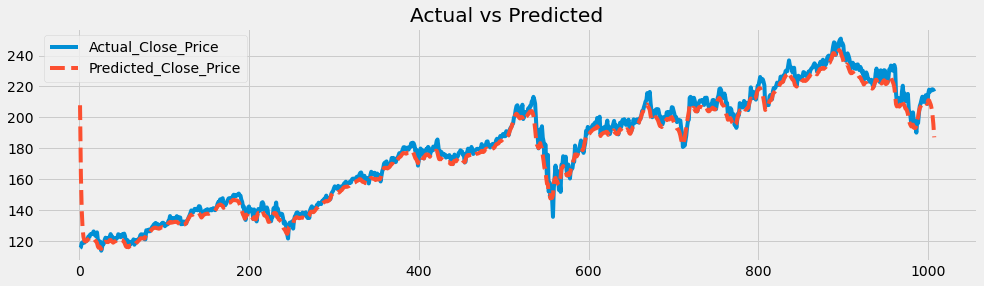

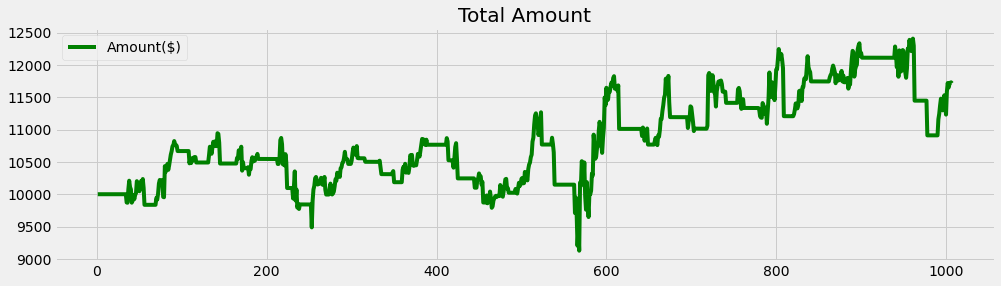

In [39]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [40]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')

Initial_Investment : 10000$
Final Amount: 11716.0 $
Profit_Percent: 117.16 %


In [41]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()


In [42]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio

0.00022285631402190956 0.01146298348266772


0.5757408878657867

# Model evaluaion

* rmse

In [43]:
from sklearn.metrics import mean_squared_error

In [44]:
rms = sqrt(mean_squared_error(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']))

In [45]:
sqrt(rms)

2.3417107763074583

* r-square

In [46]:
from sklearn.metrics import r2_score

r2_score(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']) 

0.976373896535692